In [93]:
import maia_lib
import chess
import pandas
from utils import *
from main import *
from collections import Counter
import numpy as np
import torch
from tqdm import tqdm
import threading
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import json
from typing import Dict, Any, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
class Config:
    def __init__(self):
        self.data_root = 'pgn'
        self.seed = 42
        self.num_workers = 8
        self.verbose = True
        self.max_epochs = 1
        self.max_ply = 300
        self.clock_threshold = 30
        self.chunk_size = 8000  # Note: This is a string in your argparse, but consider changing it to int if applicable
        self.start_year = 2013
        self.start_month = 1
        self.end_year = 2019
        self.end_month = 12
        self.from_checkpoint = False
        self.checkpoint_year = 2018
        self.checkpoint_month = 12
        self.test_year = 2024
        self.test_month = 1
        self.num_cpu_left = 4
        self.model = 'ViT'  # Default model type
        self.lr = 1e-4
        self.wd = 1e-5
        self.batch_size = 30000
        self.first_n_moves = 10
        self.last_n_moves = 10
        self.dim_cnn = 256
        self.dim_vit = 1024
        self.num_blocks_cnn = 5
        self.num_blocks_vit = 2
        self.input_channels = 18
        self.vit_length = 8
        self.elo_dim = 128
        self.side_info = True
        self.max_games_per_elo_range = 20
        self.value = True
        self.value_coefficient = 1
        self.side_info_coefficient = 1

In [3]:
cfg = Config()
all_moves = get_all_possible_moves()
all_moves_dict = {move: i for i, move in enumerate(all_moves)}
elo_dict = create_elo_dict()
move_dict = {v: k for k, v in all_moves_dict.items()}

trained_model_path = "weights.v2.pt"
ckpt = torch.load(trained_model_path, map_location=torch.device('cpu'))
model = MAIA2Model(len(all_moves), elo_dict, cfg)
model = torch.nn.DataParallel(model)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

{'<1100': 0, '1100-1199': 1, '1200-1299': 2, '1300-1399': 3, '1400-1499': 4, '1500-1599': 5, '1600-1699': 6, '1700-1799': 7, '1800-1899': 8, '1900-1999': 9, '>=2000': 10}


DataParallel(
  (module): MAIA2Model(
    (chess_cnn): ChessResNet(
      (conv1): Conv2d(18, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (1): BasicBlock(
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (con

In [4]:
def extract_puzzle_data(json_line):
    data = json.loads(json_line)
    fen = data['fen']
    best_move = data['evals'][0]['pvs'][0]['line'].split()[0]
    best_cp = data['evals'][0]['pvs'][0].get('cp', 100000)

    best_moves = []

    pvs = []
    for eval in data['evals']:
        for pv in eval['pvs']:
            pvs.append(pv)

    for pv in pvs:
        if abs(pv.get('cp', 0) - best_cp) < 30:
            best_moves.append(pv['line'].split()[0])

    elo_dict = {
        '<1100': 0, '1100-1199': 1, '1200-1299': 2, '1300-1399': 3, '1400-1499': 4,
        '1500-1599': 5, '1600-1699': 6, '1700-1799': 7, '1800-1899': 8, '1900-1999': 9,
        '>=2000': 10
    }

    maia_data = {}
    for elo_range, category in elo_dict.items():
        if elo_range in data:
            move_probs = data[elo_range]['move_probs']
            top_maia_move = max(move_probs, key=move_probs.get)
            best_move_prob = move_probs.get(best_move, 0)

            maia_data[category] = {
                'top_maia_move': top_maia_move,
                'best_move_prob': best_move_prob
            }

    return {
        'fen': fen,
        'best_move': best_move,
        'maia_data': maia_data,
        'best_moves': list(set(best_moves))
    }


def is_monotonic(maia_data: Dict[int, Dict[str, Any]]) -> bool:
    probs = [data['best_move_prob'] for data in maia_data.values()]
    return all(probs[i] <= probs[i + 1] for i in range(len(probs) - 1))


def is_transitional(maia_data: Dict[int, Dict[str, Any]], best_moves: List[str]) -> Tuple[bool, int]:
    moves = [data['top_maia_move'] for data in maia_data.values()]
    elo_categories = sorted(maia_data.keys())

    # Check if all moves are correct (not truly transitional)
    if all(move in best_moves for move in moves):
        return False, -1

    for x in range(1, len(elo_categories)):
        if all(moves[i] not in best_moves for i in range(x)) and \
                all(moves[i] in best_moves for i in range(x, len(moves))):
            return True, elo_categories[x]
    return False, -1


def analyze_puzzle(puzzle_data: Dict[str, Any]) -> Dict[str, Any]:
    fen = puzzle_data['fen']
    best_move = puzzle_data['best_move']
    maia_data = puzzle_data['maia_data']
    best_moves = puzzle_data['best_moves']

    monotonic = is_monotonic(maia_data)
    transitional, transition_point = is_transitional(maia_data, best_moves)
    all_correct = all(data['top_maia_move'] == best_move for data in maia_data.values())

    return {
        'fen': fen,
        'best_move': best_move,
        'maia_moves': {elo: data['top_maia_move'] for elo, data in maia_data.items()},
        'maia_probs': {elo: data['best_move_prob'] for elo, data in maia_data.items()},
        'is_monotonic': monotonic,
        'is_transitional': transitional,
        'transition_point': transition_point,
        'is_both': monotonic and transitional,
        'all_correct': all_correct,
    }


def process_puzzles(file_path, special_fens, best_transitional_moves, all_best_transitional_moves,
                    transitional_maia_moves, counters, transition_points) -> tuple:
    with open(file_path, 'r') as file:
        for line in file:
            puzzle_data = extract_puzzle_data(line)
            analyzed_data = analyze_puzzle(puzzle_data)
            # results.append(analyzed_data)

            counters['total'] += 1
            if analyzed_data['is_monotonic']:
                counters['monotonic'] += 1
                special_fens['monotonic'].append(analyzed_data['fen'])
            if analyzed_data['is_transitional']:
                counters['transitional'] += 1
                special_fens['transitional'].append(analyzed_data['fen'])
                transition_points.append(analyzed_data['transition_point'])
                best_transitional_moves.append(puzzle_data['best_move'])
                all_best_transitional_moves.append(puzzle_data['best_moves'])
                transitional_maia_moves.append(analyzed_data['maia_moves'])
            if analyzed_data['is_both']:
                counters['both'] += 1
                special_fens['both'].append(analyzed_data['fen'])
            if analyzed_data['all_correct']:
                counters['all_correct'] += 1

    # df = pd.DataFrame(results)
    return special_fens, counters, transition_points, best_transitional_moves, transitional_maia_moves


special_fens = defaultdict(list)
counters = {'total': 0, 'monotonic': 0, 'transitional': 0, 'both': 0, 'all_correct': 0}
transition_points = []
best_transitional_moves = []
all_best_transitional_moves = []
transitional_maia_moves = []

for i in tqdm(range(10)):
    file_path = f'/grace/cache/huggingface/lichess_data/lichess_db_evals_with_maia2/lichess_db_eval_chunk_{i}.jsonl'
    special_fens, counters, transition_points, best_transitional_moves, transitional_maia_moves = process_puzzles(
        file_path, special_fens, best_transitional_moves, all_best_transitional_moves, transitional_maia_moves,
        counters, transition_points)
print(transitional_maia_moves[0])
total_non_all_correct = counters['total'] - counters['all_correct']
print("Total positions:", counters['total'])
print("Positions where all Maia2 predictions are correct:", counters['all_correct'],
      f"({counters['all_correct'] / counters['total']:.2%})")
print("Monotonic positions:", counters['monotonic'], f"({counters['monotonic'] / counters['total']:.2%})")
print("Transitional positions:", counters['transitional'],
      f"({counters['transitional'] / total_non_all_correct:.2%} of non-all-correct positions)")
print("Both monotonic and transitional:", counters['both'],
      f"({counters['both'] / total_non_all_correct:.2%} of non-all-correct positions)")

with open('trans_mono_positions.json', 'w') as f:
    json.dump(special_fens, f, indent=2)

100%|█████████████| 10/10 [02:10<00:00, 13.09s/it]


{0: 'c6g2', 1: 'f7g7', 2: 'f7g7', 3: 'f7g7', 4: 'f7g7', 5: 'f7g7', 6: 'f7g7', 7: 'f7g7', 8: 'f7g7', 9: 'f7g7', 10: 'f7g7'}
Total positions: 1000000
Positions where all Maia2 predictions are correct: 315177 (31.52%)
Monotonic positions: 247684 (24.77%)
Transitional positions: 100526 (14.68% of non-all-correct positions)
Both monotonic and transitional: 50752 (7.41% of non-all-correct positions)


In [5]:
def is_piece_no_longer_under_attack(fen: str, move: str, square_index) -> bool:
    """
    Determines if a piece on the given square index was under attack before the move
    and is no longer under attack after the move.

    Parameters:
    fen (str): The FEN string representing the current board position.
    move (str): The move in UCI format (e.g., 'e2e4').
    square_index (int): The square to check, as an index between 0 and 63 (0 = 'a1', 63 = 'h8').

    Returns:
    bool: True if the piece on the square was under attack before the move but is no longer under attack after.
    """
    # Load the board from the given FEN
    board = chess.Board(fen)

    piece_before_move = board.piece_at(square_index)

    # Function to count attacks and defenses on the square
    def is_under_attack(board, square_index):
        attackers = board.attackers(chess.BLACK, square_index)  # Opponent's attackers
        defenders = board.attackers(chess.WHITE, square_index)  # Defenders (current player's pieces)

        return len(attackers) > len(defenders)

    # Check if the square is under attack before the move
    was_under_attack_before = is_under_attack(board, square_index) and piece_before_move is not None and piece_before_move.color is not chess.BLACK

    # Make the move
    move_obj = chess.Move.from_uci(move)
    if not board.is_legal(move_obj):
        raise ValueError(f"Illegal move: {move}")

    board.push(move_obj)  # Apply the move

    # Check if there is still a piece on the square after the move
    piece_after_move = board.piece_at(square_index)

    # Check if the square is still under attack after the move
    is_under_attack_after = is_under_attack(board, square_index) and piece_after_move is not None

    # Return True if it was under attack before, but is no longer under attack
    return was_under_attack_before and not is_under_attack_after

def square_index(square_name: str) -> int:
    if not isinstance(square_name, str) or len(square_name) != 2:
        raise ValueError("Square name must be a string of length 2")

    file = square_name[0].lower()
    rank = square_name[1]

    if file not in 'abcdefgh' or rank not in '12345678':
        raise ValueError("Invalid square name")

    file_index = 'abcdefgh'.index(file)
    rank_index = '12345678'.index(rank)

    return rank_index * 8 + file_index

In [6]:
def is_blunder(fen: str, uci_move: str, stockfish_path: str = 'Stockfish-sf_16/src/stockfish',
               threshold: int = 150) -> bool:
    # Load the engine
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        # Parse the FEN to create a board
        board = chess.Board(fen)

        # Create the move from the UCI string
        move = chess.Move.from_uci(uci_move)

        # Check if the move is legal
        if move not in board.legal_moves:
            return False  # Automatically return False if the move is illegal

        # Get the evaluation before the move
        info_before = engine.analyse(board, chess.engine.Limit(depth=20))
        eval_before = info_before['score'].relative.score()

        # If eval_before is None, it's a checkmate scenario, so return False (no blunder possible)
        if eval_before is None:
            return False

        # Apply the move
        board.push(move)

        # Get the evaluation after the move
        info_after = engine.analyse(board, chess.engine.Limit(depth=20))
        eval_after = info_after['score'].relative.score()

        # If eval_after is None, it's a checkmate scenario, so return False (no blunder possible)
        if eval_after is None:
            return False

        # Calculate the centipawn difference
        centipawn_loss = abs(eval_before - eval_after)

        # Check if the loss is greater than the threshold (150 centipawns)
        return centipawn_loss > threshold

In [7]:
with open('blunder_list.json', 'r') as f:
    blunder_list = json.load(f)

In [ ]:

intervention_site = []
for key, value in layer_one_features.items():
    intervention_site.append(('transformer block 1 hidden states', value[0]))
intervention_site

In [23]:
squarewise_alarmbells = {'a1': (700, 0.36075833439826965), 'b1': (700, 0.34046846628189087), 'c1': (1835, 0.21228957176208496), 'd1': (700, 0.26641276478767395), 'f1': (656, 0.38744181394577026), 'g1': (120, 1.372929573059082), 'h1': (1224, 0.35428425669670105), 'a2': (1662, 0.2485594004392624), 'b2': (1785, 0.14544463157653809), 'c2': (757, 0.2955701947212219), 'd2': (1879, 0.2876772880554199), 'e2': (1579, 0.09466977417469025), 'g2': (1453, 0.534953236579895), 'h2': (1495, 0.4493197202682495), 'a3': (416, 0.18684718012809753), 'c3': (1333, 0.3227689862251282), 'd3': (717, 0.39051148295402527), 'f3': (1308, 0.4294995367527008), 'h3': (1883, 0.1986609697341919), 'a4': (1637, 0.5537023544311523), 'b4': (1, 1.2216111421585083), 'c4': (1978, 0.3465708792209625), 'd4': (1789, 0.24516381323337555), 'e4': (603, 0.4142204821109772), 'f4': (1158, 0.20746734738349915), 'h4': (472, 0.3967437446117401), 'b5': (882, 0.4750314950942993), 'c5': (587, 0.145487979054451), 'd5': (1208, 0.28872203826904297), 'e5': (170, 0.04572858288884163), 'g5': (147, 0.09553366154432297), 'h5': (472, 1.1114749908447266), 'c6': (574, 1.6026335954666138), 'e6': (1481, 1.1328874826431274), 'b7': (455, 0.40555328130722046)}

# lookup_thresholds = {0: {}, 1:{}}
# for value in squarewise_alarmbells.values():
#     lookup_thresholds[value[0]][value[1]] = value[2]

target_key_list = ['transformer block 1 hidden states'] # 'conv_last'
all_ground_truths = []
intervention_site = []

for_ashton = {k:[] for k in [square for square in squarewise_alarmbells]}

for key, value in squarewise_alarmbells.items():
    print(key)
    layer, feature_idx = target_key_list[0], value[0]
    # layer, feature_idx = random.choice([0, 1]), random.randint(0, 2048)
    intervention_site.append((target_key_list[0], feature_idx))
    ground_truth = []
    for i in tqdm(range(len(special_fens['transitional']))):
        fen = special_fens['transitional'][i]
        move = best_transitional_moves[i]
        square_idx = square_index(key)
        try:
            no_longer_under_attack = is_piece_no_longer_under_attack(fen, move, square_idx)
            if no_longer_under_attack:
                # is_blundered = np.all(is_blunder(fen, transitional_maia_moves[i][j]) for j in range(transition_points[i]))
                # is_blundered = is_blunder(fen, transitional_maia_moves[i][0])
                is_blundered = blunder_list[i]
                temp = {"fen": fen}
                temp["transition_points"] = transition_points[i]
                temp["best_moves"] = all_best_transitional_moves[i]
                temp['blunder'] = transitional_maia_moves[i][0]
                for_ashton[key].append(temp)
                micro_gt = no_longer_under_attack and \
                            is_blundered and \
                            not np.any([is_piece_no_longer_under_attack(fen, transitional_maia_moves[i][j], square_idx) for j in range((transition_points[i]))])
                ground_truth.append(micro_gt)
            else:
                ground_truth.append(0)
        except ValueError:
            ground_truth.append(0)

            # print("illegal_move" + move)
    print(np.sum(ground_truth))
    all_ground_truths.append(ground_truth)
all_ground_truths = torch.tensor(all_ground_truths, dtype=torch.int)
# with open("non_ashtonian_relevant_positions.json", "w") as f:
#     json.dump(for_ashton, f)

a1


100%|███| 100526/100526 [00:10<00:00, 9503.96it/s]


33
b1


100%|███| 100526/100526 [00:10<00:00, 9548.76it/s]


7
c1


100%|███| 100526/100526 [00:10<00:00, 9575.60it/s]


11
d1


100%|███| 100526/100526 [00:10<00:00, 9404.68it/s]


18
f1


100%|███| 100526/100526 [00:10<00:00, 9602.58it/s]


1
g1


100%|███| 100526/100526 [00:10<00:00, 9746.42it/s]


2
h1


100%|███| 100526/100526 [00:10<00:00, 9694.40it/s]


14
a2


100%|███| 100526/100526 [00:10<00:00, 9611.79it/s]


110
b2


100%|███| 100526/100526 [00:10<00:00, 9553.36it/s]


177
c2


100%|███| 100526/100526 [00:10<00:00, 9692.77it/s]


113
d2


100%|███| 100526/100526 [00:10<00:00, 9742.92it/s]


17
e2


100%|███| 100526/100526 [00:10<00:00, 9617.05it/s]


42
g2


100%|███| 100526/100526 [00:10<00:00, 9618.34it/s]


89
h2


100%|███| 100526/100526 [00:11<00:00, 8826.75it/s]


37
a3


100%|███| 100526/100526 [00:11<00:00, 8906.80it/s]


30
c3


100%|███| 100526/100526 [00:11<00:00, 8877.43it/s]


138
d3


100%|███| 100526/100526 [00:12<00:00, 8371.44it/s]


54
f3


100%|███| 100526/100526 [00:10<00:00, 9519.23it/s]


81
h3


100%|███| 100526/100526 [00:10<00:00, 9540.55it/s]


55
a4


100%|███| 100526/100526 [00:10<00:00, 9407.91it/s]


50
b4


100%|███| 100526/100526 [00:10<00:00, 9647.24it/s]


80
c4


100%|███| 100526/100526 [00:10<00:00, 9490.34it/s]


177
d4


100%|███| 100526/100526 [00:10<00:00, 9226.84it/s]


268
e4


100%|███| 100526/100526 [00:11<00:00, 9002.32it/s]


301
f4


100%|███| 100526/100526 [00:10<00:00, 9433.22it/s]


103
h4


100%|███| 100526/100526 [00:10<00:00, 9298.12it/s]


62
b5


100%|███| 100526/100526 [00:10<00:00, 9612.46it/s]


68
c5


100%|███| 100526/100526 [00:10<00:00, 9623.48it/s]


62
d5


100%|███| 100526/100526 [00:10<00:00, 9528.02it/s]


138
e5


100%|███| 100526/100526 [00:10<00:00, 9396.74it/s]


249
g5


100%|███| 100526/100526 [00:10<00:00, 9493.57it/s]


105
h5


100%|███| 100526/100526 [00:10<00:00, 9633.89it/s]


19
c6


100%|███| 100526/100526 [00:10<00:00, 9537.41it/s]


20
e6


100%|███| 100526/100526 [00:10<00:00, 9351.42it/s]


31
b7


100%|███| 100526/100526 [00:10<00:00, 9475.67it/s]


4


In [24]:
valid_indices = [i for i in range(all_ground_truths.shape[1]) if torch.sum(all_ground_truths[:, i]) != 0]
filtered_special_fens = [special_fens['transitional'][i] for i in valid_indices]
filtered_transition_points = [transition_points[i] for i in valid_indices]
filtered_best_transitional_moves = [best_transitional_moves[i] for i in valid_indices]
filtered_all_ground_truths = all_ground_truths[:, valid_indices]
filtered_all_best_transitional_moves = [all_best_transitional_moves[i] for i in valid_indices]

In [25]:
board_fens = []
board_inputs = []
for fen in filtered_special_fens:
    board_tensor = board_to_tensor(chess.Board(fen))
    board_fens.append(fen)
    board_inputs.append(board_tensor)

board_inputs = torch.stack(board_inputs, dim=0)

In [26]:
torch.sum(filtered_all_ground_truths, dim=1)

tensor([ 33,   7,  11,  18,   1,   2,  14, 110, 177, 113,  17,  42,  89,  37,
         30, 138,  54,  81,  55,  50,  80, 177, 268, 301, 103,  62,  68,  62,
        138, 249, 105,  19,  20,  31,   4])

In [27]:
intervention_site[15]

('transformer block 1 hidden states', 1333)

In [28]:
sae_dim = 2048
sae_lr = 1e-05
sae_site = "res"
sae_date = "2023-12"
sae = torch.load(f'sae/trained_saes_{sae_date}-{sae_dim}-{sae_lr}-{sae_site}.pt')
target_key_list = ['transformer block 0 hidden states', 'transformer block 1 hidden states'] # 'conv_last'

In [29]:
def _enable_activation_hook(model, cfg):
    def get_activation(name):
        def hook(model, input, output):
            if not hasattr(_thread_local, 'residual_streams'):
                _thread_local.residual_streams = {}
            _thread_local.residual_streams[name] = output.detach()
        return hook
        
    for i in range(cfg.num_blocks_vit):
        feedforward_module = model.module.transformer.elo_layers[i][1]
        feedforward_module.register_forward_hook(get_activation(f'transformer block {i} hidden states'))

def apply_sae_to_activations(sae, activations, target_key_list):
    sae_activations = {}
    for key in target_key_list:
        if key in activations and key in sae:
            # act = activations[key].view(-1, activations[key].size(-1))
            act = torch.mean(activations[key], dim=1)
            # print(act.shape)
            encoded = nn.functional.linear(act, sae[key]['encoder_DF.weight'], sae[key]['encoder_DF.bias'])
            encoded = nn.functional.relu(encoded)
            
            sae_activations[key] = encoded
    
    return sae_activations

def apply_sae_to_reconstruction(sae, activations, target_key_list):
    sae_activations = {}
    for key in target_key_list:
        if key in activations and key in sae:
            act = torch.mean(activations[key], dim=1)
            encoded = nn.functional.linear(act, sae[key]['encoder_DF.weight'], sae[key]['encoder_DF.bias'])
            encoded = nn.functional.relu(encoded)
            decoded = nn.functional.linear(encoded, sae[key]['decoder_FD.weight'], sae[key]['decoder_FD.bias'])
            
            sae_activations[key] = decoded
    
    return sae_activations

def get_legal_moves_idx(board, all_moves_dict):
    legal_moves = torch.zeros(len(all_moves_dict))
    legal_moves_idx = []
    for move in board.legal_moves:
        move_uci = move.uci()
        if move_uci in all_moves_dict:
            legal_moves_idx.append(all_moves_dict[move_uci])
    legal_moves_idx = torch.tensor(legal_moves_idx)
    legal_moves[legal_moves_idx] = 1
    return legal_moves

In [30]:
def _enable_intervention_hook(model, cfg):
    def get_intervention_hook(name):
        def hook(module, input, output):
            if not hasattr(_thread_local, 'residual_streams'):
                _thread_local.residual_streams = {}
            _thread_local.residual_streams[name] = output.detach()
            if hasattr(_thread_local, 'modified_values') and name in _thread_local.modified_values:
                return _thread_local.modified_values[name]
            return None
        return hook
    
    for i in range(cfg.num_blocks_vit):
        feedforward_module = model.module.transformer.elo_layers[i][1]
        feedforward_module.register_forward_hook(
            get_intervention_hook(f'transformer block {i} hidden states')
        )

def set_modified_values(modified_dict):
    _thread_local.modified_values = modified_dict

def clear_modified_values():
    if hasattr(_thread_local, 'modified_values'):
        del _thread_local.modified_values

In [105]:
layer_one_features = squarewise_alarmbells.copy()
elo_range = range(len(elo_dict) - 1)
candidate_strength = [0.1, 0.2, 0.5, 1, 2, 5, 10]
target_transition_points = [filtered_transition_points[i] for i in column_indexes.tolist()]

original_results_dict = {
    k: {
        strength: {elo: [0, 0] for elo in elo_range}
        for strength in candidate_strength
    }
    for k in [key for key, value in layer_one_features.items()]
}
intervened_results_dict = {
    k: {
        strength: {elo: [0, 0] for elo in elo_range}
        for strength in candidate_strength
    }
    for k in [key for key, value in layer_one_features.items()]
}
transition_points_deviation = {k:{strength: {} for strength in candidate_strength} for k in [key for key, value in layer_one_features.items()]}

for specific_square_name in layer_one_features.keys():
        
        #specific_square_name = "h3"
        specific_square_idx_gt = 0
        for key, value in layer_one_features.items():
            if key == specific_square_name:
                break
            specific_square_idx_gt += 1
        
        print(specific_square_name, torch.sum(filtered_all_ground_truths, dim=1)[specific_square_idx_gt])
        if torch.sum(filtered_all_ground_truths, dim=1)[specific_square_idx_gt] < 20: # not enough samples
            continue

        specific_square_idx = intervention_site[specific_square_idx_gt][1]
        
        _thread_local = threading.local()
        _enable_activation_hook(model, cfg)
        # target_key_list = ['transformer block 0 hidden states', 'transformer block 1 hidden states']
        # all_sae_activations = {key: [] for key in target_key_list}
        # all_sae_reconstruct = {key: [] for key in target_key_list}
        intervened_pred_list = []
        
        legal_moves_list = []
        for fen in filtered_special_fens:
            board = chess.Board(fen)
            legal_moves_list.append(get_legal_moves_idx(board, all_moves_dict))
        legal_moves = torch.stack(legal_moves_list)
        
        column_indexes = torch.where(filtered_all_ground_truths[specific_square_idx_gt] == 1)[0]
        target_boards = board_inputs[column_indexes, :, :, :]
        target_legal_moves = legal_moves[column_indexes, :]
        target_all_best_moves = [filtered_all_best_transitional_moves[i] for i in column_indexes.tolist()]
        target_transition_points = [filtered_transition_points[i] for i in column_indexes.tolist()]

        for intervention_strength in candidate_strength:
            print(intervention_strength)
            elos_self = torch.zeros(len(target_boards))
            elos_oppo = torch.zeros(len(target_boards))
            epsilon = 0.005
        
            #original_results_dict = {k: {elo: [0, 0] for elo in elo_range} for k in [key for key, value in layer_one_features.items()]}
            #intervened_results_dict = {k: {elo: [0, 0] for elo in elo_range} for k in [key for key, value in layer_one_features.items()]}
            intervened_pred_list = []
            
            for elo in elo_range:
            
                elos_self = elos_self.fill_(elo).long()
                elos_oppo = elos_oppo.fill_(elo).long()
            
                # Clean Run
                with torch.no_grad():
                    logits_maia, logits_side_info, logits_value = model(target_boards, elos_self, elos_oppo)
                    activations = getattr(_thread_local, 'residual_streams', {})
                    sae_activations = apply_sae_to_activations(sae, activations, target_key_list)
                    sae_reconstruct_activations = apply_sae_to_reconstruction(sae, activations, target_key_list)
                    # for key in target_key_list:
                    #     if key in activations:
                    #         all_sae_activations[key].append(sae_activations[key])
                    #         all_sae_reconstruct[key].append(sae_reconstruct_activations[key])
                
                    logits_maia_legal = logits_maia * target_legal_moves
                    preds = logits_maia_legal.argmax(dim=-1)
            
                # Intervention
                intervened_sae_activations = {}
                for key in sae_activations:
                    intervened_sae_activations[key] = sae_activations[key].clone()
                
                threshold_statistics = {k:[0, 0] for k in [val[1] for val in squarewise_alarmbells.values()]}
                
                # for i in range(filtered_all_ground_truths.shape[1]):
                #     for j in range(filtered_all_ground_truths.shape[0]):
                #         if filtered_all_ground_truths[j][i] == 1:
                layer, feature_idx = intervention_site[specific_square_idx_gt]
                intervened_sae_activations[layer][:, feature_idx] += epsilon
                intervened_sae_activations[layer][:, feature_idx] *= intervention_strength
                    
                reconstructed_activations = {}
                for key in intervened_sae_activations:
                    reconstructed_activations[key] = nn.functional.linear(intervened_sae_activations[key], sae[key]['decoder_FD.weight'], 
                                                                          sae[key]['decoder_FD.bias']).unsqueeze(1).expand(-1, 8, -1)
            
                # intervene_site = 'transformer block 1 hidden states'
                _enable_intervention_hook(model, cfg)
                set_modified_values(reconstructed_activations)
                with torch.no_grad():
                    intervened_logits_maia, intervened_logits_side_info, intervened_logits_value = model(target_boards, elos_self, elos_oppo)
                    intervened_logits_maia_legal = intervened_logits_maia * target_legal_moves
                    intervened_preds = intervened_logits_maia_legal.argmax(dim=-1)
                clear_modified_values()
            
                intervened_pred_list.append(intervened_preds)
            
                # Best move rate
            
                print(f"Maia 2 Strength: {elo}")
                original_cnt = 0
            
                for i in range(target_boards.shape[0]):
                    pred = move_dict[preds[i].item()]
                    if pred in target_all_best_moves[i]:
                        original_cnt += 1
                        if elo:
                            original_results_dict[specific_square_name][intervention_strength][elo][1] += 1
                    else:
                        original_results_dict[specific_square_name][intervention_strength][elo][0] += 1
                                
                original_cnt /= target_boards.shape[0]
                print(f"Original rate for predicting the best {specific_square_name} move: {original_results_dict[specific_square_name][intervention_strength][elo][1]/(original_results_dict[specific_square_name][intervention_strength][elo][0]+original_results_dict[specific_square_name][intervention_strength][elo][1])}")
                # print(f"Original rate for predicting the best move: {original_cnt}")
                # print(original_results_dict)
            
                intervened_cnt = 0
                for i in range(target_boards.shape[0]):
                    pred = move_dict[intervened_preds[i].item()]
                    if pred in target_all_best_moves[i]:
                        intervened_cnt += 1
                        intervened_results_dict[specific_square_name][intervention_strength][elo][1] += 1
                    else:
                        intervened_results_dict[specific_square_name][intervention_strength][elo][0] += 1
                intervened_cnt /= target_boards.shape[1]
                # print(f"Intervened rate for predicting the best move: {intervened_cnt}")
                # print(intervened_results_dict)
            
                print(f"Intervened rate for predicting the best {specific_square_name} move:{intervened_results_dict[specific_square_name][intervention_strength][elo][1]/(intervened_results_dict[specific_square_name][intervention_strength][elo][0]+intervened_results_dict[specific_square_name][intervention_strength][elo][1])}")

            intervened_pred_list = torch.stack(intervened_pred_list, dim=0)
            intervened_transition_points = []
            for i in range(intervened_pred_list.shape[1]):
                intervened = False
                for j in range(1, len(elo_dict) - 1):
                    if all(move_dict[intervened_pred_list[k][i].item()] not in target_all_best_moves[i] for k in range(j)) and \
                       all(move_dict[intervened_pred_list[k][i].item()] in target_all_best_moves[i] for k in range(j, len(elo_dict) - 1)):
                           intervened_transition_points.append(j)
                           intervened = True
                if not intervened:
                    intervened_transition_points.append(-1)
            
            cnt = 0
            tot_sum = 0
            for i in range(intervened_pred_list.shape[1]):
                if intervened_transition_points[i] != -1:
                    cnt += 1
                    tot_sum += (target_transition_points[i] - intervened_transition_points[i])
            
            if cnt:
                deviation = tot_sum/cnt
            else:
                deviation = 0
            transition_points_deviation[specific_square_name][intervention_strength] = deviation

a1 tensor(33)
0.1
Maia 2 Strength: 0
Original rate for predicting the best a1 move: 0.0
Intervened rate for predicting the best a1 move:0.030303030303030304
Maia 2 Strength: 1
Original rate for predicting the best a1 move: 0.36363636363636365
Intervened rate for predicting the best a1 move:0.3333333333333333
Maia 2 Strength: 2
Original rate for predicting the best a1 move: 0.5151515151515151
Intervened rate for predicting the best a1 move:0.45454545454545453
Maia 2 Strength: 3
Original rate for predicting the best a1 move: 0.5151515151515151
Intervened rate for predicting the best a1 move:0.5454545454545454
Maia 2 Strength: 4
Original rate for predicting the best a1 move: 0.6666666666666666
Intervened rate for predicting the best a1 move:0.5757575757575758
Maia 2 Strength: 5
Original rate for predicting the best a1 move: 0.6666666666666666
Intervened rate for predicting the best a1 move:0.6363636363636364
Maia 2 Strength: 6
Original rate for predicting the best a1 move: 0.7878787878787

In [106]:
transition_points_deviation

{'a1': {0.1: -0.14814814814814814,
  0.2: -0.14814814814814814,
  0.5: -0.07407407407407407,
  1: 0.03571428571428571,
  2: 0.17857142857142858,
  5: 0.23076923076923078,
  10: 0.3333333333333333},
 'b1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'c1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'd1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'f1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'g1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'h1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'a2': {0.1: -0.046875,
  0.2: -0.03125,
  0.5: -0.015625,
  1: 0.015151515151515152,
  2: 0.045454545454545456,
  5: 0.203125,
  10: 0.15517241379310345},
 'b2': {0.1: 0.008064516129032258,
  0.2: 0.024193548387096774,
  0.5: 0.024390243902439025,
  1: 0.040983606557377046,
  2: 0.07377049180327869,
  5: 0.1487603305785124,
  10: 0.24369747899159663},
 'c2': {0.1: 0.012987012987012988,
  0.2: 0.0,
  0.5: 0.0

In [89]:
def find_best_accuracies(original_results_dict, intervened_results_dict):
    best_accuracies = {}
    original_accuracies = {}
    
    for square in original_results_dict.keys():
        best_accuracies[square] = {}
        original_accuracies[square] = {}
        
        for elo in range(10):  # Assuming 10 ELO levels (0-9)
            best_acc = None
            original_acc = None
            
            for strength in original_results_dict[square].keys():
                if sum(original_results_dict[square][strength][elo]) and sum(intervened_results_dict[square][strength][elo]):
                    current_original_acc = original_results_dict[square][strength][elo][1] / sum(original_results_dict[square][strength][elo])
                    current_intervened_acc = intervened_results_dict[square][strength][elo][1] / sum(intervened_results_dict[square][strength][elo])
                    
                    if best_acc is None or current_intervened_acc > best_acc:
                        best_acc = current_intervened_acc
                    
                    if original_acc is None:
                        original_acc = current_original_acc
            
            if best_acc is not None:
                best_accuracies[square][elo] = best_acc
            if original_acc is not None:
                original_accuracies[square][elo] = original_acc
    
    return best_accuracies, original_accuracies

best_accuracies, original_accuracies = find_best_accuracies(original_results_dict, intervened_results_dict)
avg_best_accuracies = {}
avg_original_accuracies = {}

for elo in range(10):
    best_acc_sum = sum(square_acc[elo] for square_acc in best_accuracies.values() if elo in square_acc)
    best_acc_count = sum(1 for square_acc in best_accuracies.values() if elo in square_acc)
    
    original_acc_sum = sum(square_acc[elo] for square_acc in original_accuracies.values() if elo in square_acc)
    original_acc_count = sum(1 for square_acc in original_accuracies.values() if elo in square_acc)
    
    if best_acc_count > 0:
        avg_best_accuracies[elo] = best_acc_sum / best_acc_count
    
    if original_acc_count > 0:
        avg_original_accuracies[elo] = original_acc_sum / original_acc_count

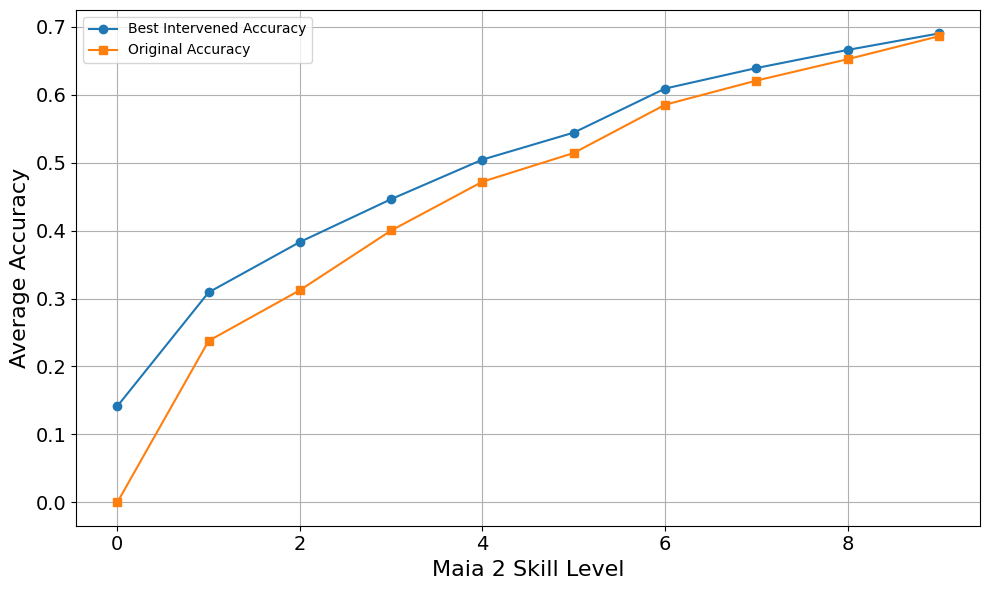

Average Intervened Accuracies:
ELO 0: 0.1415
ELO 1: 0.3091
ELO 2: 0.3832
ELO 3: 0.4464
ELO 4: 0.5045
ELO 5: 0.5443
ELO 6: 0.6091
ELO 7: 0.6393
ELO 8: 0.6660
ELO 9: 0.6903

Average Original Accuracies:
ELO 0: 0.0000
ELO 1: 0.2377
ELO 2: 0.3123
ELO 3: 0.4002
ELO 4: 0.4720
ELO 5: 0.5143
ELO 6: 0.5853
ELO 7: 0.6209
ELO 8: 0.6524
ELO 9: 0.6862


In [95]:
plt.figure(figsize=(10, 6))
plt.plot(avg_best_accuracies.keys(), avg_best_accuracies.values(), marker='o', label='Best Intervened Accuracy')
plt.plot(avg_original_accuracies.keys(), avg_original_accuracies.values(), marker='s', label='Original Accuracy')

plt.xlabel('Maia 2 Skill Level', fontsize=16)
plt.ylabel('Average Accuracy', fontsize=16)
# plt.title('Average Accuracy vs ELO Level')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('average_accuracy_vs_elo.pdf')
plt.show()

print("Average Intervened Accuracies:")
for elo, acc in avg_best_accuracies.items():
    print(f"ELO {elo}: {acc:.4f}")

print("\nAverage Original Accuracies:")
for elo, acc in avg_original_accuracies.items():
    print(f"ELO {elo}: {acc:.4f}")

In [109]:
transition_points_deviation

{'a1': {0.1: -0.14814814814814814,
  0.2: -0.14814814814814814,
  0.5: -0.07407407407407407,
  1: 0.03571428571428571,
  2: 0.17857142857142858,
  5: 0.23076923076923078,
  10: 0.3333333333333333},
 'b1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'c1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'd1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'f1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'g1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'h1': {0.1: {}, 0.2: {}, 0.5: {}, 1: {}, 2: {}, 5: {}, 10: {}},
 'a2': {0.1: -0.046875,
  0.2: -0.03125,
  0.5: -0.015625,
  1: 0.015151515151515152,
  2: 0.045454545454545456,
  5: 0.203125,
  10: 0.15517241379310345},
 'b2': {0.1: 0.008064516129032258,
  0.2: 0.024193548387096774,
  0.5: 0.024390243902439025,
  1: 0.040983606557377046,
  2: 0.07377049180327869,
  5: 0.1487603305785124,
  10: 0.24369747899159663},
 'c2': {0.1: 0.012987012987012988,
  0.2: 0.0,
  0.5: 0.0

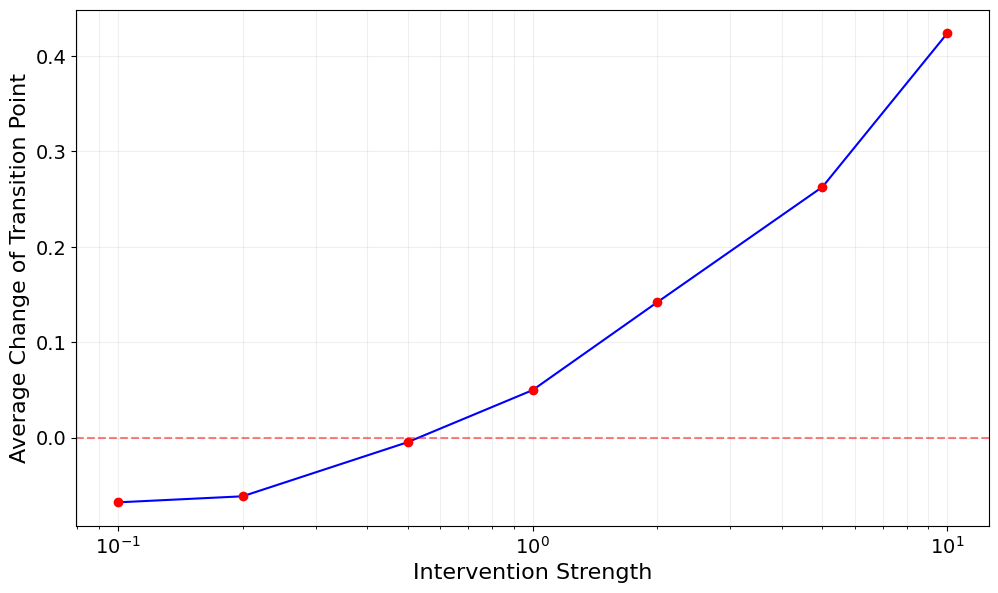

Strength 0.1: -0.06798257020565278
Strength 0.2: -0.061634316520532424
Strength 0.5: -0.004918473708009441
Strength 1.0: 0.04962437223925241
Strength 2.0: 0.14192181976832552
Strength 5.0: 0.2627277656929206
Strength 10.0: 0.42389068798276947


In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def average_deviations(transition_points_deviation):
    avg_deviations = {}
    for strength in candidate_strength:
        total = 0
        count = 0
        for square in transition_points_deviation:
            if strength in transition_points_deviation[square] and transition_points_deviation[square][strength] != {}:
                total += transition_points_deviation[square][strength]
                count += 1
        if count > 0:
            avg_deviations[float(strength)] = total / count
    return avg_deviations

# Average the deviations
avg_deviations = average_deviations(transition_points_deviation)

# Prepare data for plotting
x = list(avg_deviations.keys())
y = list(avg_deviations.values())

# Create a smooth curve
# x_smooth = np.logspace(np.log10(min(x)), np.log10(max(x)), 300)
# spl = make_interp_spline(x, y, k=3)
# y_smooth = spl(x_smooth)

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(x, y, 'b-')
plt.scatter(x, y, color='red', zorder=5)  # Add original points

plt.xlabel('Intervention Strength', fontsize=16)
plt.ylabel('Average Change of Transition Point', fontsize=16)
# plt.title('Average Transition Point Deviation vs Intervention Strength', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=14)

plt.savefig('average_deviation_vs_strength.pdf')
plt.show()

for strength, deviation in sorted(avg_deviations.items()):
    print(f"Strength {strength}: {deviation}")